## Pipeline

#### Camera calibration
#### Distortion correction
#### Color/gradient threshold
#### Perspective transform
#### Detect lane lines
#### Determine the lane curvature

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Calibrate Camera

In [3]:
import glob

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [5]:
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
#     img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Read a test image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


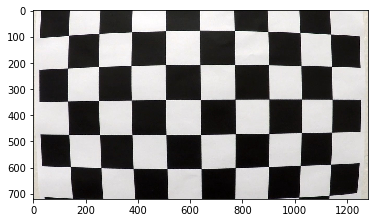

In [6]:
#reading in an image
test_cal = mpimg.imread('camera_cal/calibration1.jpg')

#printing out some stats and plotting
print('This image is:', type(test_cal), 'with dimensions:', test_cal.shape)
plt.imshow(test_cal)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [7]:
undistorted = cal_undistort(test_cal)

In [8]:
### Compare Images

In [9]:
def print2ims(im1, im2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(im1)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(im2)
    ax2.set_title('Changed Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

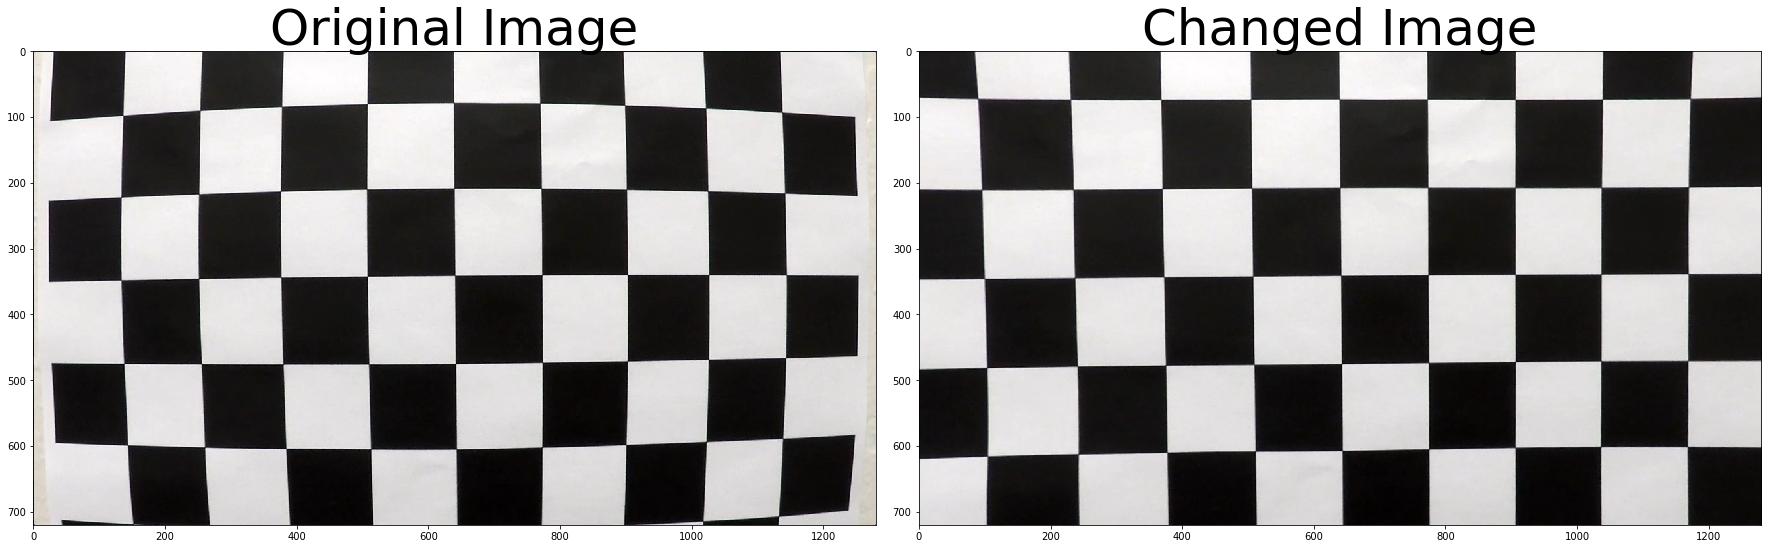

In [10]:
print2ims(test_cal, undistorted)

## Perspective Transform

In [11]:
image = mpimg.imread('test_images/straight_lines1.jpg')
# print2ims(image, cal_undistort(image))

In [12]:
src = np.float32([[700, 450],
                  [1150, 720],
                  [200, 720],
                  [590, 450]])

dst = np.float32([[1150, 0],
                  [1150, 720],
                  [300, 720],
                  [300, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
    
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [13]:
print(src[3])

[ 590.  450.]


In [14]:
# #source points
# plt.imshow(image)
# plt.plot(src[2], src[0], color='g', linestyle='-', linewidth=2)
# plt.plot(src[1], src[3], color='k', linestyle='-', linewidth=2)
# plt.plot([450, 700], [450, 590], color='g', linestyle='-', linewidth=2)
# plt.plot(src[1], src[3], color='k', linestyle='-', linewidth=2)

In [15]:
# #destination points
# plt.imshow(image)
# plt.plot(60, 720, '.')  # bottom left
# plt.plot(1200, 720, '.') # bottom right
# plt.plot(60, 0, '*')  # top left
# plt.plot(1200, 0, '.')  # top right

In [16]:
image = cal_undistort(image)
warped = warp(image)

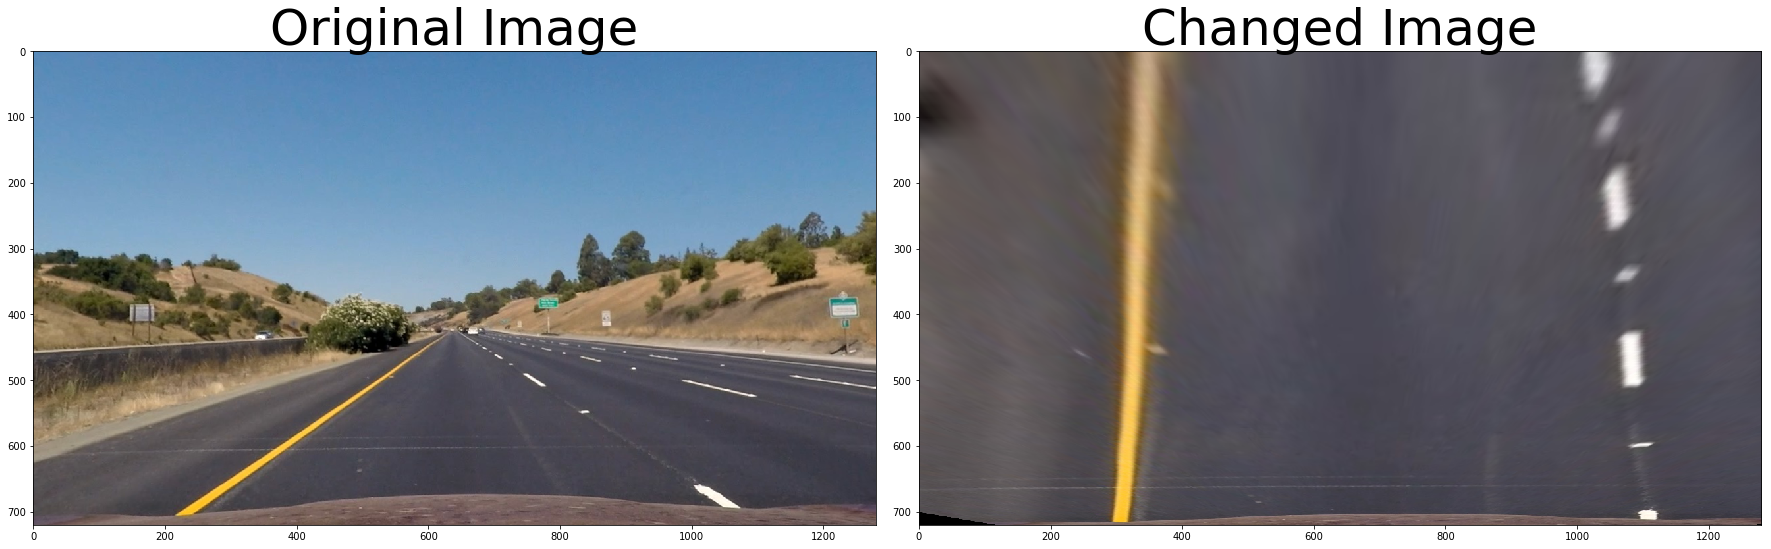

In [17]:
print2ims(image, warped)

In [18]:
# Sobel

In [19]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
     # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [20]:
# Magnitude of the Gradient

In [21]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [22]:
# Direction of the Gradient

In [23]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [24]:
# COMBINE SOBEL_X AND SBINARY

In [25]:
def pipeline(img):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

In [26]:
# color_binary, combined_binary = pipeline(test5)

# # Plot the result
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()

# ax1.imshow(color_binary)
# ax1.set_title('Stacked thresholds', fontsize=40)

# ax2.imshow(combined_binary, cmap='gray')
# ax2.set_title('Combined S channel and gradient thresholds', fontsize=40)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [27]:
# warped = warp(combined_binary)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()

# ax1.imshow(combined_binary, cmap='gray')
# ax1.set_title('Original', fontsize=40)

# ax2.imshow(warped, cmap='gray')
# ax2.set_title('Warped', fontsize=40)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

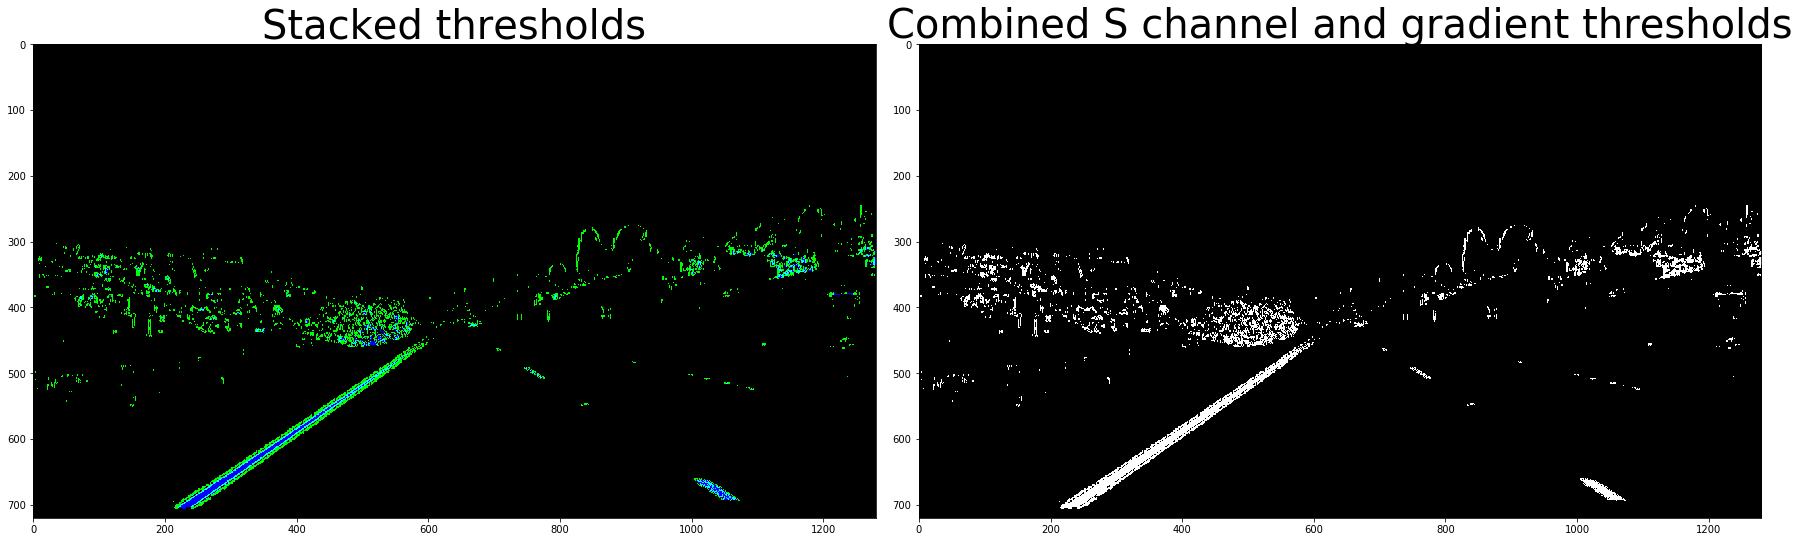

In [28]:
color_binary, combined_binary = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_binary)
ax1.set_title('Stacked thresholds', fontsize=40)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined S channel and gradient thresholds', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

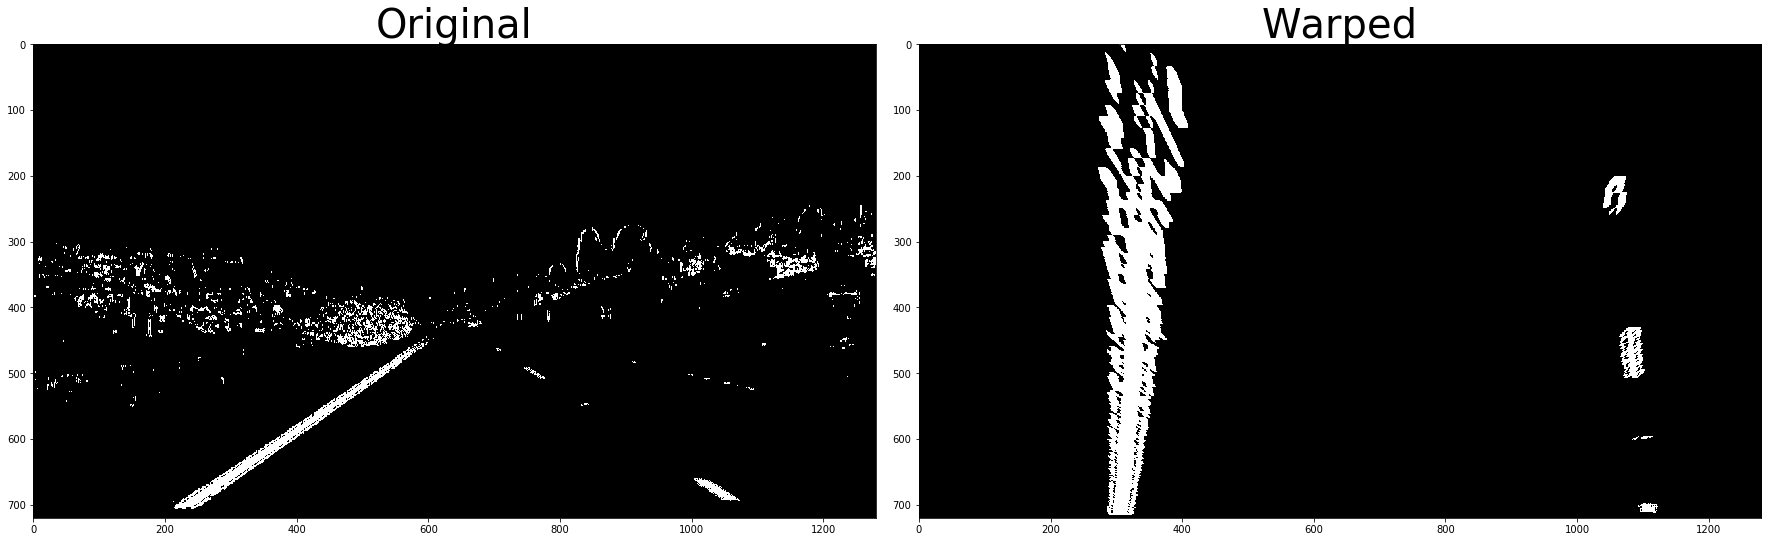

In [29]:
warped = warp(combined_binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Original', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find the Lines

In [30]:
binary_warped = warped

In [111]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
prev_righty = 0
def findLines(binary_warped):
    global prev_righty
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    if(righty.size == 0):
        righty = rightx
    if(rightx.size == 0):
        rightx = righty
    try:
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        right_fit = [1,1,1]
        
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #warped = warp(combined_binary)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    #warp_zero = np.zeros_like(test5)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_LINEAR) 
    
    # ------- Find the curvature here and place it on the image: -------
    
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature = "Radius of Curvature: {} m".format(int((left_curverad + right_curverad)/2))
    cv2.putText(newwarp,curvature,(100,50), font, 1,(0,255,255),2)
    
    # ------- Find Car Position -----
    
    lane_center = (right_fitx[-1] + left_fitx[-1]) / 2.0 
    #line_center = (np.median(right_fitx) - np.median(left_fitx)) / 2.0 + np.median(left_fitx)
    camera_position = binary_warped.shape[1] / 2
    offset = (camera_position - lane_center) * xm_per_pix
    
    position = "Position offset: {: .4f} m".format((offset))
    cv2.putText(newwarp,position,(100,150), font, 1,(0,255,255),2)
    
    return out_img, left_fitx, right_fitx, ploty, newwarp

In [ ]:
## Test on Videos

In [44]:
def process_image2(image, count):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    undist = cal_undistort(image)
    path = './IMG_result/undist'+str(count)+'.jpg'
    cv2.imwrite(path, undist)
    _, combined = pipeline(undist)
    path = './IMG_result/combined'+str(count)+'.jpg'
    cv2.imwrite(path, combined)
    warped = warp(combined)
    path = './IMG_result/warped'+str(count)+'.jpg'
    cv2.imwrite(path, warped)
    lined = findLines(warped)
    path = './IMG_result/lined'+str(count)+'.jpg'
    cv2.imwrite(path, lined)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, lined, 0.3, 0)
    path = './IMG_result/result'+str(count)+'.jpg'
    cv2.imwrite(path, result)
    return result

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    undist = cal_undistort(image)
    _, combined = pipeline(undist)
    warped = warp(combined)
    _, _, _, _, lined = findLines(warped)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, lined, 0.3, 0)
    return result

In [38]:
### Visualize

(720, 0)

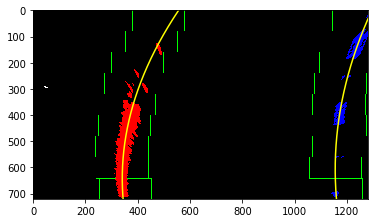

In [88]:
image = mpimg.imread('test_images/test1.jpg')
undist = cal_undistort(image)
_, combined = pipeline(undist)
warped = warp(combined)
out_img, left_fitx, right_fitx, ploty, newwarp = findLines(warped)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [112]:
images = glob.glob('test_images/*.jpg')
for img in images:
    image = mpimg.imread(img)
    res = process_image(image)
    cv2.imwrite('output_images/out_'+img.split('/')[-1],res)

In [94]:
import imageio
imageio.plugins.ffmpeg.download()

In [93]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [95]:
output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(output, audio=False, verbose=False)

100%|█████████▉| 1260/1261 [04:24<00:00,  4.88it/s]


In [96]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))